node1 assigned address 10.0.0.1
node2 assigned address 10.0.0.2
node3 assigned address 10.0.0.3
node4 assigned address 10.0.0.4
node5 assigned address 10.0.0.5
node6 assigned address 10.0.0.6
node7 assigned address 10.0.0.7
node8 assigned address 10.0.0.8
node9 assigned address 10.0.0.9
node10 assigned address 10.0.0.10
node11 assigned address 10.0.0.11
node12 assigned address 10.0.0.12
node13 assigned address 10.0.0.13
node14 assigned address 10.0.0.14
node15 assigned address 10.0.0.15
node1 assigned network prefix 2001:db8:0000::24
node2 assigned network prefix 2001:db8:0001::24
node3 assigned network prefix 2001:db8:0002::24
node4 assigned network prefix 2001:db8:0003::24
node5 assigned network prefix 2001:db8:0004::24
node6 assigned network prefix 2001:db8:0005::24
node7 assigned network prefix 2001:db8:0006::24
node8 assigned network prefix 2001:db8:0007::24
node9 assigned network prefix 2001:db8:0008::24
node10 assigned network prefix 2001:db8:0009::24
node11 assigned network pre

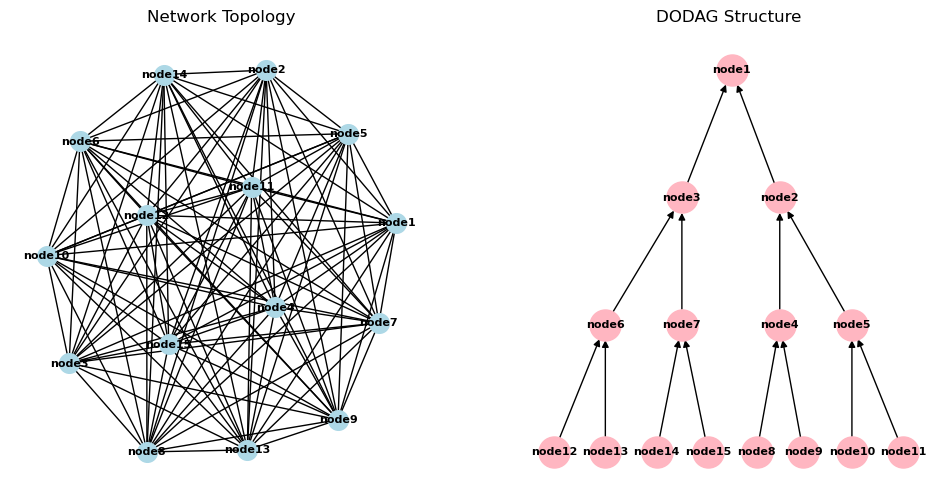

In [1]:
import simpy
import networkx as nx
import matplotlib.pyplot as plt
import random
import time

# Constants for the simulation
SIM_TIME = 20000  # Increased simulation time
MAX_DISTANCE = 65
MAX_CHILDREN = 2
AREA_SIZE = (100, 100)
PREFIX_LENGTH = 24  # Length of the network prefix

class Network:
    def __init__(self, env):
        self.env = env
        self.nodes = []
        self.G_network = nx.Graph()
        self.G_dodag = nx.DiGraph()

    def add_node(self, node):
        self.nodes.append(node)
        self.G_network.add_node(node.name)

    def add_edge(self, node1, node2):
        self.G_network.add_edge(node1.name, node2.name)

    def visualize(self):
        # Network Topology Visualization
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        pos = nx.spring_layout(self.G_network)
        nx.draw(self.G_network, pos, with_labels=True, node_color='lightblue', node_size=200, font_size=8, font_weight='bold')
        plt.title('Network Topology')

        # DODAG Structure Visualization
        plt.subplot(122)
        G_dodag = nx.DiGraph()
        for node in self.nodes:
            if node.parent:
                G_dodag.add_edge(node.name, node.parent.name)  # Reverse the direction for visualization
        pos = nx.nx_agraph.graphviz_layout(G_dodag, prog='dot')
        pos_flipped = {node: (x, -y) for node, (x, y) in pos.items()}
        nx.draw(G_dodag, pos_flipped, with_labels=True, node_color='lightpink', node_size=500, font_size=8, font_weight='bold', arrows=True)
        plt.title('DODAG Structure')
        plt.show()


class Node:
    def __init__(self, network, name, rank=float('inf'), position=None):
        self.network = network
        self.name = name
        self.rank = rank
        self.position = position or (random.uniform(0, AREA_SIZE[0]), random.uniform(0, AREA_SIZE[1]))
        self.neighbors = []
        self.parent = None
        self.children = []
        self.dao_sent = False
        self.address = f"10.0.0.{len(self.network.nodes)+1}"
        self.routing_table = {}
        self.prefix = None
        print(f"{self.name} assigned address {self.address}")
        self.dist_to_all_nodes = {child: float('inf') for child in self.network.nodes}
        self.dist_to_children = {child: float('inf') for child in self.children}

    def assign_prefix(self, prefix):
        self.prefix = prefix
        print(f"{self.name} assigned network prefix {self.prefix}")

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)
        self.network.add_edge(self, neighbor)

    def send_dio(self, recipient):
        print(f"{self.name} sends DIO to {recipient.name}")
        yield self.network.env.timeout(1)
        recipient.receive_dio(self)

    def receive_dio(self, sender):
        if self.name == 'node1':
            return
        if (self.parent is None or sender.rank < self.parent.rank) and len(sender.children) < MAX_CHILDREN:
            if self.parent:
                self.parent.children.remove(self)  # Remove self from the old parent's children list
            self.parent = sender
            self.rank = sender.rank + 1
            sender.children.append(self)
            print(f"{self.name} receives DIO from {sender.name} and sets {sender.name} as parent (Rank: {self.rank})")
            self.network.env.process(self.send_dao())

    def send_dao(self):
        if not self.dao_sent and self.parent:
            print(f"{self.name} sends DAO to {self.parent.name}")
            self.dao_sent = True
            yield self.network.env.timeout(1)
            self.parent.receive_dao(self)

    def receive_dao(self, sender):
        if sender.prefix:
            self.routing_table[sender.prefix] = sender.name
            self.update_routing_table(sender)

            print(f"{self.name} updated routing table with {sender.prefix} from {sender.name}")
            self.print_routing_table()

    def update_routing_table(self, sender):
        self.dist_to_all_nodes[sender] = 1
        self.dist_to_children[sender] = 1

        for child in sender.children:
            if child not in self.dist_to_all_nodes:
                self.dist_to_all_nodes[child] = self.dist_to_all_nodes[sender] + 1
                self.routing_table[f"{child.prefix}/{PREFIX_LENGTH+1}"] = child.name
                self.update_routing_table(child)

    def print_routing_table(self):
        print(f"Routing Table for {self.name}:")
        print("{:<20} {:<20}".format("Network Prefix", "Hop"))
        for prefix, next_hop in self.routing_table.items():
            print("{:<20} {:<20}".format(prefix, next_hop))
        print("\n")

def run_simulation(num_nodes):
    start_time = time.time()

    env = simpy.Environment()
    network = Network(env)

    for i in range(num_nodes):
        name = f"node{i+1}"
        rank = 0 if name == 'node1' else float('inf')  # Set rank to 0 for node1, else infinity
        position = (random.uniform(0, AREA_SIZE[0]), random.uniform(0, AREA_SIZE[1]))
        node = Node(network, name, rank, position)
        network.add_node(node)

    for i, node in enumerate(network.nodes):
        prefix = f"2001:db8:{i:04x}::{PREFIX_LENGTH}"
        node.assign_prefix(prefix)

    for node in network.nodes:
        for other_node in network.nodes:
            if node != other_node:
                node.add_neighbor(other_node)

    for node in network.nodes:
        for neighbor in node.neighbors:
            env.process(node.send_dio(neighbor))

    env.run(until=SIM_TIME)

    for node in network.nodes:
        parent_name = node.parent.name if node.parent else 'None'
        children_names = [child.name for child in node.children]
        position_formatted = f"({node.position[0]:.2f}, {node.position[1]:.2f})"
        print(f"Node: {node.name}, Parent: {parent_name}, Children: {children_names}, Rank: {node.rank}")
        node.print_routing_table()

    end_time = time.time()
    print(f"Total simulation time: {end_time - start_time:.2f} seconds")

    network.visualize()

if __name__ == "__main__":
    run_simulation(15)  # Adjust the number of nodes as needed